# RSE SkillShare day Keras Tutorial

Getting to grips with Keras for predicting binding motifs for DNA or RNA binding proteins.

Useful references:

[Predicting the sequence specificities of DNA- and RNA-binding proteins by deep learning, Alipanahi et al., 2015](https://www.nature.com/articles/nbt.3300)

env: KERAS_BACKEND=tensorflow


Using TensorFlow backend.


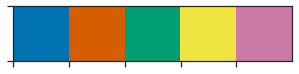

In [2]:
import sys
import os
from glob import glob
import random
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import h5py

%env KERAS_BACKEND tensorflow
import tensorflow as tf
from keras import (
    models, layers, activations,
    optimizers, losses, callbacks, utils
)
import keras.backend as K

from sklearn.metrics import (
    roc_curve, precision_recall_curve, roc_auc_score
)
from sklearn.model_selection import KFold, train_test_split
from sklearn.utils import shuffle


## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

We have a ChIP-seq dataset for the DNA binding protein CCCTC-binding factor (CTCF) in a human cell line, taken from the ENCODE Uniform Peaks of Transcription Factor ChIP-seq project. We would like to build a model to predict the binding motif of CTCF in new sequences and interpret what the sequence motif might be (pretending that we don't know its called CCCTC-binding factor which is a bit of a giveaway). We could use a motif discovery and prediction toolkit such as the MEME suite to do this, but of course we want to be fancy and use neural networks. So, where to start?

Data preprocessing is key! First we need to convert our protein binding sites from interval data (narrowPeak format) to sequences. But there are a lot of things to consider....

* **What will our negative training examples be?** To train a model we need both positive examples (sequences which are detected in the ChIPseq dataset) and negative examples (???). So what do we use for negative examples? We could randomly shuffle the intervals through the genome and use this to extract negative sequences, but this might give us a biased set if our positive examples are from specific regions of the genome (the human genome is mostly intergenic and these regions have different sequence compositions to intragenic regions). We could control for this in the shuffling, e.g. if our protein binds in open chromatin, we could randomly shuffle our intervals within open chromatin regions... Another solution that is often used is to randomly shuffle the sequences of the positive training set, but keeping the nucleotide and dinuclotide frequencies of each sequence constant. This provides a background set with similar properties to the positive set, but with higher order patterns in the sequences randomised.
* **How should we process our input data?** Most machine learning models require uniform features as input, but our ChIPseq peaks are all different lengths! One way to address this could be to extract features such as trinucleotide frequencies from the sequences, but this is lossy and kind of defeats the purpose of using a more complex model like a neural net. Because the narrowPeak format contains a single base "summit" which is the middle of the peak, we could also extract a fixed length window centered on this summit.
* **How should we encode our input data?** Sequence data is categorical (the categories being A, C, G, or T) but Keras models do not understand categorical input. We can therefore use "dummy" variables to encode our sequence as a Nx4 binary matrix.
* **Can we augment our input data?** Data augmentation can be useful to artificially inflate the amount of training data and prevent the model from overfitting. Examples of augmentation include rotations, skews or reflections applied to images, or random noise applied to continuous variables. It is harder to augment categorical data, but one thing we can do with the ChIPseq data is apply reverse complementation, as the ChIP peaks are unstranded.

### Preprocessing:

Lets start our training data preprocessing... we already have peaks from the CTCF ChIPseq dataset in narrowpeak format, but are they all the same length...?

[(290, 29179),
 (196, 241),
 (202, 238),
 (198, 227),
 (203, 225),
 (214, 219),
 (201, 218),
 (192, 217),
 (195, 216),
 (207, 215)]


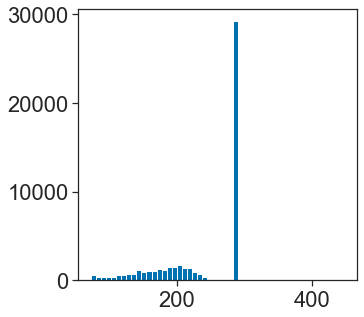

In [3]:
peaks = pd.read_csv(
    'data/ctcf.narrowPeak.gz',
    sep='\t',
    names=['chrom', 'start', 'end', 'name', 'score', 'strand',
           'signal_value', 'p_value', 'q_value', 'summit'],
    na_values=['.', '-1']
)
peaks['peak_length'] = peaks.end - peaks.start
pprint(Counter(peaks.peak_length).most_common(10))

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(peaks.peak_length, bins=50)
plt.show()

Most of the peaks seem to be 290 nt long but there are also quite a few shorter ones. Perhaps we could try using a 64 nt window centred on the summit to start with...

In [4]:
# To save people having to download hg19 to extract these sequences, I have already processed them:

positive_training_examples = pd.read_csv(
    'data/ctcf_summit_centred_seqs.tsv',
    sep='\t',
    names=['inv', 'seq']
)
positive_training_examples['label'] = 1

positive_training_examples.head()

,inv,seq,label
0,CHR1:237722-237786,GATGTGGTTTCTCCTCAGTTTCTCTGTGCAGCACCAGGTGGCAGCA...,1
1,CHR1:521552-521616,AGGTCAGCAAGGCAAACCCGAGCCCGGGGATGCGGGGTGGGGGCAG...,1
2,CHR1:714219-714283,TGAGCTGGCAGTTCTGTGTCGCTAGGCTTCTGCCCGGCCGCCGCCG...,1
3,CHR1:785920-785984,TCAAGGACTGCTGCTGCACCCTGCTGGCTCTTCCTGCACTCCCTGC...,1
4,CHR1:805265-805329,CTGGGCACGCCCTCCCGCGGCTCCGGAGCCGGCTGCCACCAGGGGG...,1


Now we need to create our negative training set, which will be a set of shuffled sequences each with identical dinucleotide frequency to a positive example. To do this we can use a nice tool called ushuffle:

In [5]:
def kmer_freqs(seq, k=2):
    return Counter([seq[i:i+k] for i in range(len(seq) - k + 1)])

seq = 'TTTACACGTGATTT'
kmer_freqs(seq)

Counter({'TT': 4,
         'TA': 1,
         'AC': 2,
         'CA': 1,
         'CG': 1,
         'GT': 1,
         'TG': 1,
         'GA': 1,
         'AT': 1})

In [6]:
from ushuffle import shuffle as ushuffle

def ushuffle_str(seq, k):
    shuf = ushuffle(seq.encode(), k)
    return shuf.decode()

shuffled = ushuffle_str(seq, 2)
print(seq, shuffled)

assert kmer_freqs(seq) == kmer_freqs(shuffled)

TTTACACGTGATTT TTTTACACGATGTT


In [7]:
negative_training_examples = []
for seq in positive_training_examples.seq:
    negative_training_examples.append([None, ushuffle_str(seq, 2), 0])
negative_training_examples = pd.DataFrame(
    negative_training_examples, columns=['inv', 'seq', 'label'])
negative_training_examples.head()

,inv,seq,label
0,None,GCAGGCTGATGGCCAAGAGTTTGGTTCAGTCCTCAACTGCTCACAA...,0
1,None,ACAAGGTGCCGGGAAGAAGTGCCCCTCAGGGGCAGCTTCTACATCG...,0
2,None,TAGAGCGCCTGCCGTTAGAGCCGCGCTGTGGGCACTGCCCGTCTCA...,0
3,None,TCTCTGCACTGAACTCCTGTGCTTGCACCTCTGGCCAGACTGCCCA...,0
4,None,CTCGGGCGCACGGGGGCACCTGCGGAGCCCGCCGTCCCGGGGGCAG...,0


In [8]:
training_examples = pd.concat(
    [negative_training_examples, positive_training_examples]
).sample(frac=1)
training_examples.head()

,inv,seq,label
23685,CHR19:51286984-51287048,GGCTGAGAAAATAGTGCAACACCGCCACTATGTGGTTATTTGGAGT...,1
2442,None,GGCTTCAACCGCATTGAGGGAACGCCCGTCCCTTCCGCGACGCAGC...,0
18975,None,GTACTAATAGTGCACCCACATGCACTTATTGCCATTCGCTTCAAAG...,0
46686,None,CCCCTCTGTGCTCTATCTGACACTTGTCCCCTGCAAAAAGATTTGC...,0
13810,None,CCGTCTTAGTCGGCCTGGGCATTTTCCAGCCATCTCGTAGGCTTGC...,0


Ok, now that we have positive and negative training examples, we need to encode them using dummy variables:

In [9]:
SEQ_OHE = {'A': [1, 0, 0, 0],
           'C': [0, 1, 0, 0],
           'G': [0, 0, 1, 0],
           'T': [0, 0, 0, 1],
           'N': [0, 0, 0, 0]}


def one_hot_sequence(seq):
    ohe = []
    for base in seq:
        try:
            ohe.append(SEQ_OHE[base])
        except KeyError:
            ohe.append(SEQ_OHE['N'])
    return np.array(ohe)

pprint(one_hot_sequence('CACGTGN'))

array([[0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 0]])


In [10]:
X_data = np.array([
    one_hot_sequence(seq) for seq in training_examples.seq
])
y_data = training_examples.label.values.astype(np.uint).reshape(-1, 1)

print(X_data.shape, y_data.shape)

(101848, 64, 4) (101848, 1)


We have training data! When training the model it is important to have a hold out test set which is used to evaluate the performance of the model and make sure it is not overfitting. The best practice would be to split the data a number of times and train multiple models on different splits (cross validation) however in the interest of time we are not going to do this today...

In [11]:
# we can use some of the helper functions from sklearn to do our splitting
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25)
print(X_train.shape, X_test.shape)

(76386, 64, 4) (25462, 64, 4)


### Training:

OK, now lets try fitting some models!

Before we start I should quickly point out some of the important terms... The Keras library is layed out nicely in modules using these terms:

* `models`: Wrapper classes such as `Sequential` or `Model` are in the `models` module and represent the high level model. Useful methods include `compile`, `fit`, `predict`, and `summary`.
* `layers`: A single layer of the neural network. The number of units for the layer can be specificied at instantiation. Layers are stacked by consecutive addition to a `Sequential` model or by being called on the previous layer using the functional API. Not all layers have weights and can be trained. Layer types include:
  * `Dense`: A fully connected layer
  * `Conv1D` or `Conv2D`: A convolutional layer in one or two dimensions
  * `LSTM`: Long short term memory Recurrent layer
  * `MaxPooling1D` or `MaxPooling2D`: A downsampling layer using the max function. Has no weights.
  * `Flatten`, `Add`, `Concatenate`: Operation layers that alter the shape of a tensor or merge two or more tensors together using a specific function.
  * `Dropout`: A "regularisation" layer that turns off certain input weights during training. This helps to prevent overfitting.
* `activations`: Functions which are applied to the output of a layer. For example:
  * `relu`: Rectified Linear Unit, performs max(x, 0) operation. Often used between dense or convolutional layers.
  * `sigmoid`: Sigmoid function, squishes input between 0 and 1. Used for final layer in binary classification problems.
  * `softmax`: Equivalent of sigmoid for multiclass classification problems, creates a probablity for each class such that the sum of the probabilities is equal to 1.
* `losses`: Function which evaluates the performance of the model on the training and validation data. Examples include `binary_crossentropy` (for two-class classification problems), `categorical_crossentropy` (for multi-class classification problems) and `mean_squared_error` (for regression problems).
* `optimizers`: Algorithms which update the parameters of the model in order to minimize the output of the loss function on the training data. Examples include `SGD` (Stochastic Gradient Descent), `Adam`, `Adadelta`, and `RMSprop` (look them up!). Most important parameter of these is the learning rate `lr`.
* `callbacks`: Utilities which perform some function at the end of each epoch, such as finishing training early if the validation loss has stopped decreasing, or saving a model checkpoint.

We can start with a simple multi-layer perceptron (densely connected model). These are not the best for sequence data because they are not position/translation invariant (i.e. if the sequence feature of interest starts at different positions in different training examples it might not be recognised correctly).

In [12]:
# Keras has two model building APIs. For simple models where all layers are
# stacked consecutively the Sequential API is suitable

mlp = models.Sequential()

# layers are added to the model and are automatically stacked up sequentially.
# The first and last layers are automatically used as the input/output
mlp.add(layers.Dense(units=128, activation='relu', input_shape=(64, 4)))
mlp.add(layers.Dense(units=128, activation='relu'))
mlp.add(layers.Dense(units=64, activation='relu'))
mlp.add(layers.Flatten())
# we can use a Dropout layer to prevent outfitting during training
mlp.add(layers.Dropout(rate=0.5))

mlp.add(layers.Dense(32, activation='relu'))
mlp.add(layers.Dense(units=1, activation='sigmoid'))

mlp.compile(
    optimizer='adam', # The algorithm used to fit the model to the data
    loss='binary_crossentropy' # How the performance of the model is evaluated
)

mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64, 128)           640       
_________________________________________________________________
dense_2 (Dense)              (None, 64, 128)           16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64, 64)            8256      
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                131104    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total para

In [14]:
es = callbacks.EarlyStopping(min_delta=0.005, patience=3, verbose=1)

mlp.fit(
    X_train, y_train,
    validation_split=0.1, # use 10% of the training data for validation at the end of each epoch
    epochs=100, # training is split up into epochs, each training example is used once per epoch
    batch_size=128, # epochs are split up into minibatches, this determines batch size
                    # smaller batch sizes should converge in fewer epochs, but training is slower (less parallelised)
    verbose=2, # verbose=1 prints progressbar with training loss at end of each batch, but doesn't work
               # very well on jupyter unfortunately. verbose=2 just prints at the end of each epoch.
    callbacks=[es,] # early stopping halts training if validation loss is no longer reducing
)

Train on 68747 samples, validate on 7639 samples
Epoch 1/100
 - 9s - loss: 0.6185 - val_loss: 0.5991
Epoch 2/100
 - 9s - loss: 0.5914 - val_loss: 0.5852
Epoch 3/100
 - 9s - loss: 0.5800 - val_loss: 0.5760
Epoch 4/100
 - 9s - loss: 0.5685 - val_loss: 0.5660
Epoch 5/100
 - 9s - loss: 0.5597 - val_loss: 0.5685
Epoch 6/100
 - 9s - loss: 0.5547 - val_loss: 0.5632
Epoch 7/100
 - 9s - loss: 0.5479 - val_loss: 0.5551
Epoch 8/100
 - 9s - loss: 0.5435 - val_loss: 0.5508
Epoch 9/100
 - 9s - loss: 0.5409 - val_loss: 0.5508
Epoch 10/100
 - 9s - loss: 0.5371 - val_loss: 0.5515
Epoch 00010: early stopping


We can evaluate the performance of the model on the test data using a Receiver Operator Characteristic curve:

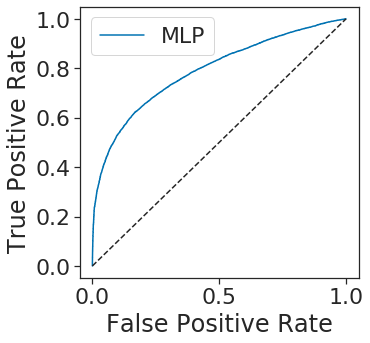

In [14]:
RESULTS = {}

def evaluate_model(model, model_name, X_test, y_test):
    y_pred = model.predict(X_test)
    # ROC curve function from sklearn.metrics
    fpr, tpr, thresh = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    RESULTS[model_name] = {
        'fpr': fpr, 'tpr': tpr, 'auc': auc, 'model': model
    }
    
    fig, ax = plt.subplots(figsize=(5, 5))
    for model_name in RESULTS:
        ax.plot(
            RESULTS[model_name]['fpr'],
            RESULTS[model_name]['tpr'],
            label=model_name
        )
    ax.plot([0, 1], [0, 1], ls='--', color='#252525')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()
    return fig, ax

evaluate_model(mlp, 'MLP', X_test, y_test)
plt.show()

Lets try a recurrent neural network. In terms of the amount of code required RNNs seem very simple! But the Keras implementation is a bit slow on CPU

In [18]:
# The other Keras model API is functional. Each layer
# object is callable. It can be called on another layer
# to connect them:

input_layer = layers.Input(shape=(64, 4))
# Bidirectional wrapper creates two LSTMs that run in opposite directions along the sequence
prev = layers.Bidirectional(layers.LSTM(8))(input_layer)
prev = layers.Dense(32, activation='relu')(prev)
prev = layers.Dropout(rate=0.5)(prev)
output_layer = layers.Dense(1, activation='sigmoid')(prev)

# Once we have our layers we create a model specifying the
# input and the output. If we want a multi-input or 
# mult-output model we could pass a list of several layers.
lstm = models.Model(input_layer, output_layer)

lstm.compile(
    optimizer=optimizers.RMSprop(lr=1e-2), # RMSprop is generally a better optimiser for RNN
    loss='binary_crossentropy'
)
lstm.build((None, 128, 4))
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 4)             0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 16)                832       
_________________________________________________________________
dense_10 (Dense)             (None, 32)                544       
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________


Note that this model has a lot fewer parameters than the previous densely connected model but because of the more complex LSTM layer should perform just as well or better

In [19]:
es = callbacks.EarlyStopping(min_delta=0.005, patience=5, verbose=1)

# Learning rate decay reduces learning rate when the loss function stops going down:
lrd = callbacks.ReduceLROnPlateau(
    min_delta=0.005, factor=0.1, patience=3, verbose=1
)

lstm.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es, lrd]
)

Train on 68747 samples, validate on 7639 samples
Epoch 1/100
 - 54s - loss: 0.6665 - val_loss: 0.6822
Epoch 2/100
 - 52s - loss: 0.5845 - val_loss: 0.5887
Epoch 3/100
 - 53s - loss: 0.5142 - val_loss: 0.4817
Epoch 4/100
 - 53s - loss: 0.4802 - val_loss: 0.4816
Epoch 5/100
 - 52s - loss: 0.4577 - val_loss: 0.5409
Epoch 6/100
 - 52s - loss: 0.4416 - val_loss: 0.4460
Epoch 7/100
 - 52s - loss: 0.4308 - val_loss: 0.4061
Epoch 8/100
 - 52s - loss: 0.4168 - val_loss: 0.4219
Epoch 9/100
 - 53s - loss: 0.4037 - val_loss: 0.3934
Epoch 10/100
 - 52s - loss: 0.3940 - val_loss: 0.3729
Epoch 11/100
 - 51s - loss: 0.3908 - val_loss: 0.4626
Epoch 12/100
 - 51s - loss: 0.3830 - val_loss: 0.3909
Epoch 13/100
 - 51s - loss: 0.3788 - val_loss: 0.3712

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 14/100
 - 51s - loss: 0.3493 - val_loss: 0.3437
Epoch 15/100
 - 51s - loss: 0.3451 - val_loss: 0.3413
Epoch 16/100
 - 52s - loss: 0.3430 - val_loss: 0.3405
Epoch 17/100
 -

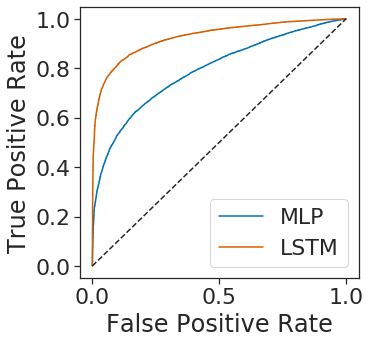

In [20]:
evaluate_model(lstm, 'LSTM', X_test, y_test)
plt.show()

We can also try a mixed convolutional/recurrent architechture. This has been used with some success on biological data [(Quang et al. 2016)](https://www.ncbi.nlm.nih.gov/pubmed/27084946) as it can identify short range features with the conv layers and longer range features with the RNN.

In [24]:
conv_lstm = models.Sequential()
conv_lstm.add(layers.Conv1D(8,
                            kernel_size=3,
                            padding='same',
                            input_shape=(64, 4)))
conv_lstm.add(layers.Conv1D(8, kernel_size=3, padding='same'))
conv_lstm.add(layers.MaxPooling1D(pool_size=2)) # Max pooling layer downsamples input by half
                                                # using the max function.
                                                # sort of equivalent to x.reshape(-1, 2).max(1)
conv_lstm.add(
    layers.Bidirectional(layers.LSTM(8))
)
conv_lstm.add(layers.Dense(units=32, activation='relu'))
conv_lstm.add(layers.Dropout(rate=0.5))
conv_lstm.add(layers.Dense(units=1, activation='sigmoid'))

conv_lstm.compile(
    optimizer=optimizers.RMSprop(lr=1e-2),
    loss='binary_crossentropy'
)
conv_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 64, 8)             104       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 64, 8)             200       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 32, 8)             0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 16)                1088      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                544       
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total para

In [25]:
es = callbacks.EarlyStopping(min_delta=0.005, patience=5, verbose=1)
lrd = callbacks.ReduceLROnPlateau(
    min_delta=0.005, factor=0.1, patience=3, verbose=1)

conv_lstm.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es, lrd]
)

Train on 68747 samples, validate on 7639 samples
Epoch 1/100
 - 31s - loss: 0.5978 - val_loss: 0.5278
Epoch 2/100
 - 29s - loss: 0.4640 - val_loss: 0.4572
Epoch 3/100
 - 29s - loss: 0.4317 - val_loss: 0.4090
Epoch 4/100
 - 29s - loss: 0.4159 - val_loss: 0.4278
Epoch 5/100
 - 29s - loss: 0.4061 - val_loss: 0.3891
Epoch 6/100
 - 29s - loss: 0.4002 - val_loss: 0.4122
Epoch 7/100
 - 29s - loss: 0.3963 - val_loss: 0.3869
Epoch 8/100
 - 29s - loss: 0.3923 - val_loss: 0.4033

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 9/100
 - 29s - loss: 0.3487 - val_loss: 0.3533
Epoch 10/100
 - 29s - loss: 0.3410 - val_loss: 0.3477
Epoch 11/100
 - 29s - loss: 0.3367 - val_loss: 0.3456
Epoch 12/100
 - 29s - loss: 0.3346 - val_loss: 0.3450
Epoch 13/100
 - 29s - loss: 0.3330 - val_loss: 0.3432

Epoch 00013: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 14/100
 - 29s - loss: 0.3281 - val_loss: 0.3405
Epoch 15/100
 - 29s - loss: 0.3265 - val_l

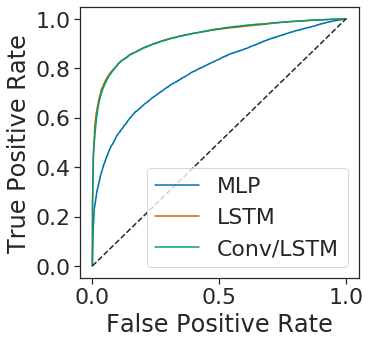

In [26]:
evaluate_model(conv_lstm, 'Conv/LSTM', X_test, y_test)
plt.show()

Finally, lets try a few fully convolutional networks. Not only have I found these to perform better on sequence data, they are also quicker to train the RNNs.

First lets try a simple sequential CNN:

In [27]:
cnn = models.Sequential()
for _ in range(3):
    cnn.add(layers.Conv1D(8, kernel_size=3, padding='same'))
    cnn.add(layers.BatchNormalization()) # this is a normalisation layer than scales mean 
                                           # of each batch to ~0 and stdev to ~1
    cnn.add(layers.Conv1D(8, kernel_size=3, padding='same'))
    cnn.add(layers.BatchNormalization())
    cnn.add(layers.Activation('relu')) # Activation function which is equivalent to max(x, 0)
    cnn.add(layers.MaxPooling1D(pool_size=2))

cnn.add(layers.Flatten())

cnn.add(layers.Dense(units=32, activation='relu'))
cnn.add(layers.Dropout(rate=0.5))
cnn.add(layers.Dense(units=1, activation='sigmoid'))

cnn.compile(
    optimizer=optimizers.Adam(lr=1e-3),
    loss='binary_crossentropy'
)
# because we didn't specify the input shape for the first layer yet
# we can do it now using build
cnn.build((None, 64, 4))
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 64, 8)             104       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 8)             32        
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 64, 8)             200       
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 8)             32        
_________________________________________________________________
activation_1 (Activation)    (None, 64, 8)             0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 32, 8)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 32, 8)             200       
__________

In [28]:
es = callbacks.EarlyStopping(min_delta=0.005, patience=5, verbose=1)
lrd = callbacks.ReduceLROnPlateau(
    min_delta=0.005, factor=0.1, patience=3, verbose=1)

cnn.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es, lrd]
)

Train on 68747 samples, validate on 7639 samples
Epoch 1/100
 - 14s - loss: 0.6351 - val_loss: 0.4958
Epoch 2/100
 - 10s - loss: 0.4715 - val_loss: 0.4380
Epoch 3/100
 - 11s - loss: 0.4261 - val_loss: 0.3878
Epoch 4/100
 - 12s - loss: 0.4018 - val_loss: 0.3933
Epoch 5/100
 - 13s - loss: 0.3880 - val_loss: 0.3632
Epoch 6/100
 - 12s - loss: 0.3777 - val_loss: 0.3607
Epoch 7/100
 - 12s - loss: 0.3694 - val_loss: 0.3518
Epoch 8/100
 - 13s - loss: 0.3625 - val_loss: 0.3545
Epoch 9/100
 - 12s - loss: 0.3587 - val_loss: 0.3412
Epoch 10/100
 - 12s - loss: 0.3549 - val_loss: 0.3401
Epoch 11/100
 - 12s - loss: 0.3518 - val_loss: 0.3366
Epoch 12/100
 - 12s - loss: 0.3470 - val_loss: 0.3383

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 13/100
 - 12s - loss: 0.3379 - val_loss: 0.3275
Epoch 14/100
 - 12s - loss: 0.3354 - val_loss: 0.3274
Epoch 15/100
 - 12s - loss: 0.3358 - val_loss: 0.3266
Epoch 16/100
 - 12s - loss: 0.3363 - val_loss: 0.3270

Epoch 00016: 

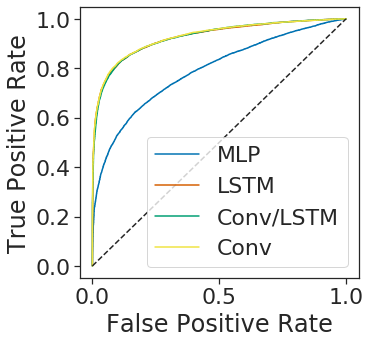

In [29]:
evaluate_model(cnn, 'Conv', X_test, y_test)
plt.show()

Finally we can try a more complicated network using the Keras functional API. This is a "deep residual" network made up of residual blocks. The residual blocks contain shortcut layers that allow the network to skip layers and pass information from the input into lower layers of the network without too much modification:

In [30]:
def residual_block(prev, num_channels, conv_type=None):
    # save a reference to the first layer so we can
    # create the shortcut...
    shortcut = prev

    # Perform two convolutions with a kernel size of 5
    prev = layers.Conv1D(num_channels,
                         kernel_size=5,
                         padding='same')(prev)
    prev = layers.BatchNormalization()(prev)
    prev = layers.Activation('relu')(prev)

    prev = layers.Conv1D(num_channels,
                         kernel_size=5,
                         padding='same')(prev)
    prev = layers.BatchNormalization()(prev)

    # This is the skip connection/shortcut layer which is
    # called on the first layer rather than the previous one
    shortcut = layers.Conv1D(num_channels,
                             kernel_size=1,
                             padding='same')(shortcut)
    shortcut = layers.BatchNormalization()(shortcut)

    # We can then merge the convolutions with the shortcut
    prev = layers.add([shortcut, prev])
    prev = layers.Activation('relu')(prev)
    return prev


def stack_convs(prev, num_channels, min_shape):
    convs = []
    while True:
        prev = residual_block(prev, num_channels)
        # stop stacking once layers have been downsampled so that the
        # tensor is only min_shape size in the spatial dimension 
        curr_shape = prev.shape.as_list()[1]
        if curr_shape <= min_shape:
            break
        convs.append(prev)
        prev = layers.MaxPool1D(2, padding='same')(prev)
    return prev


def build_resnet():
    # Functional API requires you to specify an input tensor and an output tensor
    # which 
    input_layer = layers.Input(shape=(64, 4))
    prev = stack_convs(input_layer, num_channels=8, min_shape=8)
    prev = layers.Flatten()(prev)
    prev = layers.Dense(16, activation='relu')(prev)
    prev = layers.Dropout(0.5)(prev)
    output_layer = layers.Dense(
        1, activation='sigmoid', name='binary_output')(prev)

    model = models.Model(input_layer, output_layer)
    model.compile(
        optimizer=optimizers.RMSprop(lr=1e-3),
        loss='binary_crossentropy'
    )
    return model

resnet = build_resnet()
resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 64, 4)        0                                            
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 64, 8)        168         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 64, 8)        32          conv1d_11[0][0]                  
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 64, 8)        0           batch_normalization_7[0][0]      
__________________________________________________________________________________________________
conv1d_13 

In [31]:
es = callbacks.EarlyStopping(min_delta=0.005, patience=5, verbose=1)
lrd = callbacks.ReduceLROnPlateau(
    min_delta=0.005, factor=0.1, patience=3, verbose=1)

resnet.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es, lrd]
)

Train on 68747 samples, validate on 7639 samples
Epoch 1/100
 - 16s - loss: 0.6535 - val_loss: 0.5200
Epoch 2/100
 - 12s - loss: 0.4566 - val_loss: 0.3991
Epoch 3/100
 - 12s - loss: 0.3887 - val_loss: 0.3733
Epoch 4/100
 - 12s - loss: 0.3633 - val_loss: 0.3576
Epoch 5/100
 - 12s - loss: 0.3463 - val_loss: 0.3233
Epoch 6/100
 - 12s - loss: 0.3347 - val_loss: 0.3161
Epoch 7/100
 - 12s - loss: 0.3260 - val_loss: 0.3088
Epoch 8/100
 - 12s - loss: 0.3191 - val_loss: 0.3130
Epoch 9/100
 - 12s - loss: 0.3154 - val_loss: 0.3039
Epoch 10/100
 - 12s - loss: 0.3121 - val_loss: 0.3064

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 11/100
 - 12s - loss: 0.3001 - val_loss: 0.2962
Epoch 12/100
 - 12s - loss: 0.2967 - val_loss: 0.2951
Epoch 13/100
 - 12s - loss: 0.2966 - val_loss: 0.2960
Epoch 14/100
 - 12s - loss: 0.2932 - val_loss: 0.2952

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 15/100
 - 12s - loss: 0.2938 - val

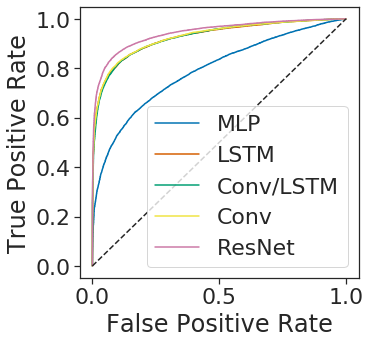

In [32]:
evaluate_model(resnet, 'ResNet', X_test, y_test)
plt.show()

### Data Augmentation:

As I mentioned earlier, data augmentation is useful for artificially inflating the number of training examples, and reducing the chance of model overfitting. Keras also has a number of nice features for data augmentation on the fly during training. These include the `Sequence` class and the `fit_generator` method of model classes. There are a few augmentations we can do for our ChIPseq data (some good examples in [this paper](https://academic.oup.com/bioinformatics/advance-article/doi/10.1093/bioinformatics/bty893/5142724)), but the easiest is reverse complementation...

In [33]:
# The Sequence class is just a way of providing slice access to the 
# data (to guarantee that each example is used once per epoch),
# whilst also allowing for augmentation at the end of each Epoch.

class RevCompAugmentor(utils.Sequence):

    def __init__(self, X_data, y_data, batch_size=128):
        self._X = X_data
        self._y = y_data
        self._batch_size = batch_size
        self._n_batches = int(np.floor(len(self._y) / batch_size))
        self.on_epoch_end()

    def on_epoch_end(self):
        # shuffle function from sklearn.utils maintains relative order of X and y.
        self._X_aug, self._y_aug = shuffle(self._X, self._y)
        self._X_aug = self._random_revcomp(self._X_aug)

    def _random_revcomp(self, X):
        # 180 deg rotation is equivalent to rev comp for these one hot encoded seqs
        X_aug = np.array([
            np.rot90(x, k=2) if random.random() > 0.5 else x
            for x in X
        ])
        return X_aug

    def __len__(self):
        # All Sequence subclasses must provide a __len__ method which
        # returns the number of batches per epoch
        return self._n_batches

    def __getitem__(self, idx):
        start = idx * self._batch_size
        end = start + self._batch_size
        return self._X_aug[start: end], self._y_aug[start: end]


# we need to create separate generators for both training and validation this time
X_train_subset, X_val, y_train_subset, y_val = train_test_split(
    X_train, y_train, shuffle=False, test_size=0.1)

train_gen = RevCompAugmentor(X_train_subset, y_train_subset)
val_gen = RevCompAugmentor(X_val, y_val)

Since the resnet worked best before we can keep using it on the augmented data:

In [34]:
resnet2 = build_resnet()

es = callbacks.EarlyStopping(min_delta=0.005, patience=5, verbose=1)
lrd = callbacks.ReduceLROnPlateau(
    min_delta=0.005, factor=0.1, patience=3, verbose=1)

resnet2.fit_generator(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    epochs=100,
    verbose=2,
    callbacks=[es, lrd]
)

Epoch 1/100
 - 13s - loss: 0.5891 - val_loss: 0.4733
Epoch 2/100
 - 9s - loss: 0.4055 - val_loss: 0.3535
Epoch 3/100
 - 9s - loss: 0.3656 - val_loss: 0.3493
Epoch 4/100
 - 10s - loss: 0.3446 - val_loss: 0.3244
Epoch 5/100
 - 9s - loss: 0.3334 - val_loss: 0.3246
Epoch 6/100
 - 9s - loss: 0.3234 - val_loss: 0.3086
Epoch 7/100
 - 9s - loss: 0.3154 - val_loss: 0.3035
Epoch 8/100
 - 9s - loss: 0.3113 - val_loss: 0.2952
Epoch 9/100
 - 9s - loss: 0.3092 - val_loss: 0.2932
Epoch 10/100
 - 9s - loss: 0.3039 - val_loss: 0.2976
Epoch 11/100
 - 9s - loss: 0.2995 - val_loss: 0.2841
Epoch 12/100
 - 9s - loss: 0.2998 - val_loss: 0.2857
Epoch 13/100
 - 9s - loss: 0.2963 - val_loss: 0.2918
Epoch 14/100
 - 9s - loss: 0.2946 - val_loss: 0.2927

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 15/100
 - 9s - loss: 0.2873 - val_loss: 0.2779
Epoch 16/100
 - 9s - loss: 0.2861 - val_loss: 0.2772
Epoch 17/100
 - 9s - loss: 0.2833 - val_loss: 0.2743
Epoch 18/100
 - 9s - los

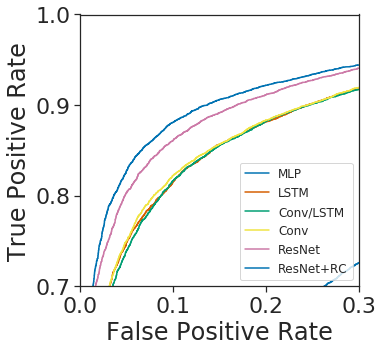

In [35]:
fig, ax = evaluate_model(resnet2, 'ResNet+RC', X_test, y_test)

# Zoom in on the top corner of the plot:
ax.set_xlim(0, 0.3)
ax.set_ylim(0.7, 1)
ax.legend_.remove()
ax.legend(fontsize=12)
plt.show()

### Model Interpretation

One criticism often leveled at neural networks is that they are "black box" functions, i.e. that it is hard to know how they are making decisions. There are a number of ways to attempt to do this interpretation, however. One fairly intuitive way is to apply a "grey patch" to the sequence at each position to obscure/occlude a region and see how it affects the prediction:

In [36]:
OHE_SEQ = np.array(['A', 'C', 'G', 'T', 'N'])
HEX_PAL = pal.as_hex()
DNA_PAL = {'A': HEX_PAL[2], 'C': HEX_PAL[0], 'G': HEX_PAL[3], 'T': HEX_PAL[1]}

def decode_ohe(seq_ohe):
    # convert a one hot encoded sequence back to a string
    idx = seq_ohe.argmax(1)
    ns = ~seq_ohe.any(1)
    idx[ns] = 4
    return ''.join(OHE_SEQ[idx])


def occlusion_importance_map(seq_ohe, model, occ_size=5):
    slen = len(seq_ohe)
    assert occ_size % 2
    w = occ_size // 2
    grey_patch = np.full(shape=(occ_size, 4), fill_value=0.25)
    occlusions = []
    # use a rolling window to apply the grey patch to the sequence
    for i in range(0, slen):
        o = seq_ohe.copy().astype('f')
        s = max(0, i - w)
        e = min(slen, i + w + 1)
        o[s: e] = grey_patch[:e - s]
        occlusions.append(o)
    occlusions = np.asarray(occlusions)
    occ_scores = model.predict(occlusions).squeeze()
    actual_score = model.predict(seq_ohe.reshape(1, 64, 4))[0]
    return occ_scores - actual_score


def plot_occlusion_importance_map(seq_ohe, model, occ_size=5, axes=None):
    seq = decode_ohe(seq_ohe)
    occ = occlusion_importance_map(seq_ohe, model, occ_size)

    if axes is None:
        fig = plt.figure(figsize=(12, 5))
        seq_ax = plt.subplot2grid(shape=(5, 1), loc=(0, 0))
        occ_ax = plt.subplot2grid(shape=(5, 1), loc=(1, 0), rowspan=4, sharex=seq_ax)
    else:
        seq_ax, occ_ax = axes.ravel()

    for i, nt in enumerate(seq):
        seq_ax.annotate(
            s=nt,
            xy=(i, 0),
            ha='left',
            va='bottom',
            family='monospace',
            fontsize=20,
            fontstretch='ultra-condensed',
            color=DNA_PAL[nt]
        )
    seq_ax.set_axis_off()
    occ_ax.plot(np.arange(len(seq)) + 0.5, occ)
    occ_ax.set_ylabel('Change in\nmodel score')
    occ_ax.set_ylim(-1, 1)
    return axes

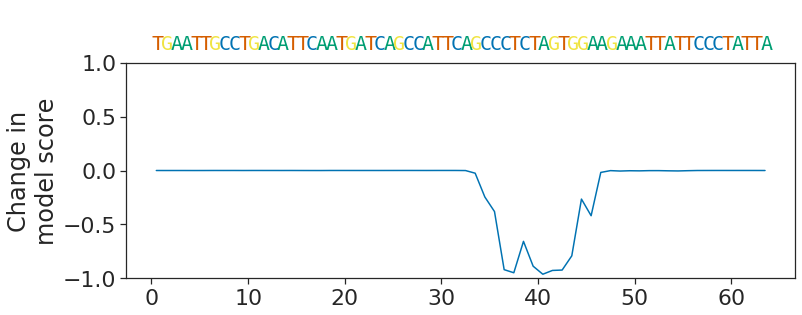

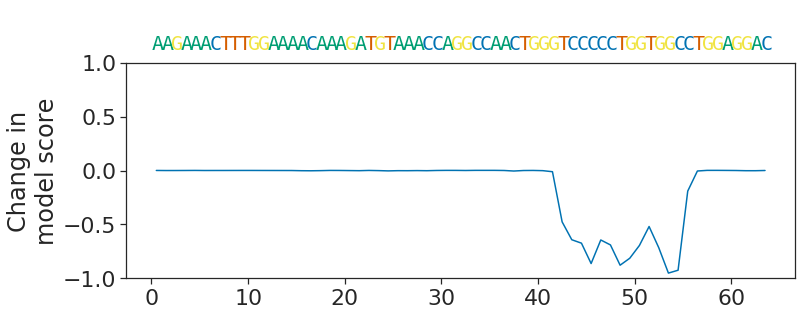

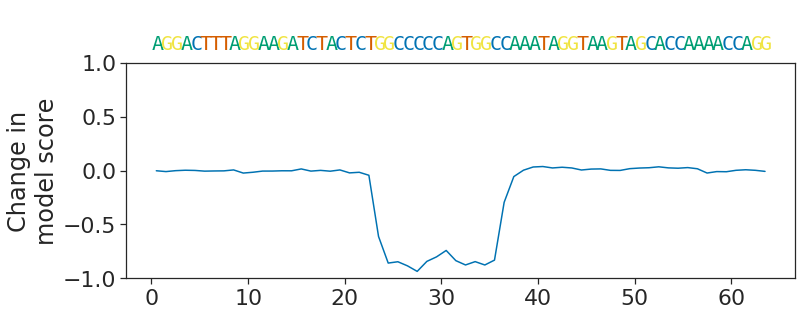

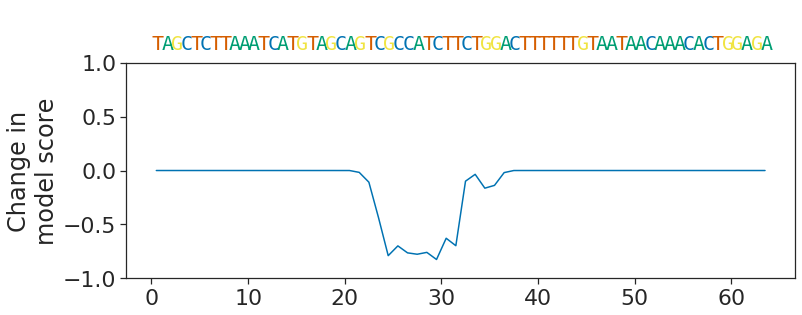

In [40]:
i = 0
j = 0
while j != 4:
    if y_test[i] == 1 and resnet.predict(X_test[i].reshape(1, 64, 4))[0][0] > 0.9:
        plot_occlusion_importance_map(X_test[i], resnet)
        plt.show()
        j += 1
    i += 1

The most important region for model prediction in this sequence seems to include the CCCTC motif which is good...

Saving models is super easy...

In [41]:
resnet.save('data/resnet_weights.h5')

As is reloading them from disk:

In [42]:
resnet_copy = models.load_model('../data/resnet_weights.h5')

OSError: Unable to open file (unable to open file: name = '../data/resnet_weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Although model files may not always be compatible across different versions of Keras